<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Micellaneous/GAN_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader, random_split, SubsetRandomSampler
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

# **Setting Up Data Loader and Loading Data**

In [3]:
def data_loader(batch_size, seed = 42, valid_size = 0.2, test = False, shuffle = True):
  # define transforms
  transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),])

  if test:
    dataset = MNIST(
          root='./data', train=False,
          download=True, transform=transform,
        )

    test_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
        )
    print('Creating test loader successfully')
    return test_loader

  train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
  num_train = len(train_dataset)
  indices = list(range(num_train))
  if shuffle:
    torch.manual_seed(seed)
    indices = torch.randperm(len(train_dataset))
  else:
    indices = torch.arange(len(train_dataset))

  train_indices, val_indices = train_test_split(indices.numpy(), test_size=valid_size, random_state=seed)
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
  val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
  print('Creating train and validation loader successfully')

  return (train_loader, val_loader)

In [4]:
# Set up the configuration
batch_size = 64
train_loader, val_loader = data_loader(batch_size=batch_size)
test_loader = data_loader(batch_size=batch_size,  test=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 104279228.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30231019.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26688784.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7372495.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Creating train and validation loader successfully
Creating test loader successfully


In [5]:
for i, (data, label) in enumerate(train_loader):
  print(data.shape)
  print(label.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
def fix_seed(seed):
  # Set seed
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

# **Discriminator and Generator**

In [7]:
num_channels = 1
num_df = num_gf = 64
num_z = 100
image_size = 28
in_features = 128 * 7 * 7

def stacked_linear_layers(in_features, config):
    layers = []
    for conf in config:
        layers += [nn.Linear(in_features, conf), nn.LeakyReLU(0.1)]
        in_features = conf

    layers += [nn.Sigmoid()]
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, classifier, init_weights=True):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, num_df, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_df, num_df*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_df*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = classifier

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the output
        x = self.classifier(x)
        x = x.view(-1)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class Generator(nn.Module):
    def __init__(self, init_weights = True):
        super(Generator, self).__init__()
        def stacked_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(True)]
            return layers

        self.generator = nn.Sequential(
            # input is Z, going into a convolution
            *stacked_block(num_z, num_gf * 8, 7, 1, 0),  # changed kernel size to 7
            # state size. (num_gf*8) x 7 x 7
            *stacked_block(num_gf * 8, num_gf * 4),  # state size. (num_gf*4) x 14 x 14
            nn.ConvTranspose2d(num_gf * 4, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
      img = self.generator(x)
      return img

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.ConvTranspose2d):
              nn.init.kaiming_normal_(m.weight,
                                      mode='fan_out',
                                      nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0)

config = {'discriminator': [128, 1],}
discriminator = Discriminator(stacked_linear_layers(in_features, config['discriminator']))
generator = Generator()

In [8]:
print(discriminator)

Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Sigmoid()
  )
)


In [9]:
print(generator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


# **Training Phase**

## **Ultis for Training**

In [10]:
import time
def fix_seed(seed):
  # Set seed
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

class Timer:
  """Record multiple running times."""
  def __init__(self):
    """Defined in :numref:`sec_minibatch_sgd`"""
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Return the average time."""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Return the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumulated time."""
    return np.array(self.times).cumsum().tolist()

In [11]:
# Set up hyperparameters
learning_rate = 0.001
# momentum = 0.9
# weight_decay = 1e-4
num_epochs = 20
seed = 42

# Check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')


# define loss function (criterion) and optimizer
criterion = nn.BCELoss()

if use_cuda:
  generator = generator.cuda()
  discriminator = discriminator.cuda()
  criterion = criterion.cuda()

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

real_label = 1
fake_label = 0

loss = {'D': [],
        'G': []}
acc  = {'real': [],
        'fake': []}

In [12]:
from tqdm import tqdm

fix_seed(seed)
# Set timer to record the computational time
timer = Timer()

for epoch in tqdm(range(num_epochs)):
  # start timer
  timer.start()

  sample_loss_D = 0.
  sample_loss_G = 0.

  # Initialize counters for real and fake correct predictions
  sample_real_acc = 0
  sample_fake_acc = 0

  total_train_samples = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    # Update Discriminator: maximize log(D(x)) + log(1 - D(g(z)))

    data = data.to(device)
    batch_size = data.size(0)
    total_train_samples += batch_size
    label = torch.full((batch_size,), real_label, device = device).float()

    # Train with real
    output = discriminator(data)
    # output = output.view(-1)
    # break
    loss_D_real = criterion(output, label)
    prob_D_real = output.mean().item()
    # Compute the number of correct predictions for real data
    sample_real_acc += (output > 0.5).sum().item()
    discriminator.zero_grad()
    # Backward pass: compute gradient of the loss with
    # respect to all the learnable parameters
    # Retain the computation graph for later backward on fake data
    loss_D_real.backward(retain_graph = True)


    # Train with fake
    noise = torch.randn(batch_size, num_z, 1, 1, device=device)
    fake = generator(noise)
    label.fill_(fake_label)
    output = discriminator(fake)
    loss_D_fake = criterion(output, label)
    # Backward pass: compute gradient of the loss with
    # respect to all the learnable parameters
    loss_D_fake.backward(retain_graph = True)
    prob_D_fake = output.mean().item()
    # Compute the number of correct predictions for fake data
    sample_fake_acc += (output < 0.5).sum().item()
    loss_D = (loss_D_real + loss_D_fake) / 2

    # Update optimizer parameters
    optimizerD.step()

    ############################
    # (2) Update G network:
    # minimize log(1 - D(G(z))) <=> maximize log(D(G(z)))
    ###########################

    label.fill_(real_label)  # fake labels are real for generator cost
    output = discriminator(fake)
    loss_G = criterion(output, label)
    generator.zero_grad()
    loss_G.backward()
    prob_G_fake = output.mean().item()
    optimizerG.step()

    sample_loss_D += loss_D.item()
    sample_loss_G += loss_G.item()



  loss_D_at_epoch = sample_loss_D / len(train_loader)
  loss_G_at_epoch = sample_loss_G / len(train_loader)

  loss['D'].append(loss_D_at_epoch)
  loss['G'].append(loss_G_at_epoch)

  acc_real_at_epoch = sample_real_acc / total_train_samples
  acc_fake_at_epoch = sample_fake_acc / total_train_samples

  acc['real'].append(acc_real_at_epoch)
  acc['fake'].append(acc_fake_at_epoch)
  # Stop the timer at the end of the epoch
  timer.stop()
  print(
      f'Epoch: [{epoch}/{num_epochs}]'
      + f' | Discriminator loss: {loss_D_at_epoch:.3f}'
      + f' | Generator loss: {loss_G_at_epoch:.3f}'
      + f' | Real accuracy: {acc_real_at_epoch:.3f}'
      + f' | Fake accuracy: {acc_fake_at_epoch:.3f}'
      + f' | Time per epoch: {timer.times[-1]:.2f} seconds')

  # Check pointing for every epoch
  # torch.save(generator.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
  # torch.save(discriminator.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))

total_time_all_epoch = timer.sum()
print(f"Total training time: {total_time_all_epoch/60:.2f} minutes")

  5%|▌         | 1/20 [00:40<12:55, 40.82s/it]

Epoch: [0/20] | Discriminator loss: 0.261 | Generator loss: 2.591 | Real accuracy: 0.887 | Fake accuracy: 0.982 | Time per epoch: 40.82 seconds


 10%|█         | 2/20 [01:15<11:05, 36.99s/it]

Epoch: [1/20] | Discriminator loss: 0.322 | Generator loss: 1.764 | Real accuracy: 0.779 | Fake accuracy: 0.964 | Time per epoch: 34.31 seconds


 15%|█▌        | 3/20 [01:49<10:09, 35.85s/it]

Epoch: [2/20] | Discriminator loss: 0.406 | Generator loss: 1.481 | Real accuracy: 0.685 | Fake accuracy: 0.949 | Time per epoch: 34.48 seconds


 20%|██        | 4/20 [02:24<09:27, 35.46s/it]

Epoch: [3/20] | Discriminator loss: 0.408 | Generator loss: 1.497 | Real accuracy: 0.684 | Fake accuracy: 0.949 | Time per epoch: 34.87 seconds


 25%|██▌       | 5/20 [02:59<08:47, 35.15s/it]

Epoch: [4/20] | Discriminator loss: 0.407 | Generator loss: 1.578 | Real accuracy: 0.668 | Fake accuracy: 0.951 | Time per epoch: 34.60 seconds


 30%|███       | 6/20 [03:33<08:07, 34.80s/it]

Epoch: [5/20] | Discriminator loss: 0.402 | Generator loss: 1.574 | Real accuracy: 0.664 | Fake accuracy: 0.953 | Time per epoch: 34.12 seconds


 35%|███▌      | 7/20 [04:07<07:30, 34.68s/it]

Epoch: [6/20] | Discriminator loss: 0.407 | Generator loss: 1.637 | Real accuracy: 0.663 | Fake accuracy: 0.952 | Time per epoch: 34.42 seconds


 40%|████      | 8/20 [04:41<06:53, 34.48s/it]

Epoch: [7/20] | Discriminator loss: 0.397 | Generator loss: 1.655 | Real accuracy: 0.659 | Fake accuracy: 0.955 | Time per epoch: 34.04 seconds


 45%|████▌     | 9/20 [05:20<06:32, 35.70s/it]

Epoch: [8/20] | Discriminator loss: 0.401 | Generator loss: 1.690 | Real accuracy: 0.650 | Fake accuracy: 0.954 | Time per epoch: 38.38 seconds


 50%|█████     | 10/20 [05:54<05:54, 35.41s/it]

Epoch: [9/20] | Discriminator loss: 0.381 | Generator loss: 1.741 | Real accuracy: 0.671 | Fake accuracy: 0.958 | Time per epoch: 34.77 seconds


 55%|█████▌    | 11/20 [06:29<05:16, 35.20s/it]

Epoch: [10/20] | Discriminator loss: 0.396 | Generator loss: 1.719 | Real accuracy: 0.652 | Fake accuracy: 0.955 | Time per epoch: 34.71 seconds


 60%|██████    | 12/20 [07:04<04:39, 34.98s/it]

Epoch: [11/20] | Discriminator loss: 0.387 | Generator loss: 1.758 | Real accuracy: 0.665 | Fake accuracy: 0.958 | Time per epoch: 34.47 seconds


 65%|██████▌   | 13/20 [07:38<04:03, 34.81s/it]

Epoch: [12/20] | Discriminator loss: 0.372 | Generator loss: 1.773 | Real accuracy: 0.678 | Fake accuracy: 0.958 | Time per epoch: 34.42 seconds


 70%|███████   | 14/20 [08:13<03:29, 34.93s/it]

Epoch: [13/20] | Discriminator loss: 0.372 | Generator loss: 1.835 | Real accuracy: 0.672 | Fake accuracy: 0.961 | Time per epoch: 35.21 seconds


 75%|███████▌  | 15/20 [08:48<02:53, 34.76s/it]

Epoch: [14/20] | Discriminator loss: 0.371 | Generator loss: 1.885 | Real accuracy: 0.680 | Fake accuracy: 0.960 | Time per epoch: 34.37 seconds


 80%|████████  | 16/20 [09:22<02:18, 34.62s/it]

Epoch: [15/20] | Discriminator loss: 0.366 | Generator loss: 1.862 | Real accuracy: 0.678 | Fake accuracy: 0.961 | Time per epoch: 34.27 seconds


 85%|████████▌ | 17/20 [09:56<01:43, 34.51s/it]

Epoch: [16/20] | Discriminator loss: 0.369 | Generator loss: 1.837 | Real accuracy: 0.675 | Fake accuracy: 0.960 | Time per epoch: 34.25 seconds


 90%|█████████ | 18/20 [10:30<01:08, 34.46s/it]

Epoch: [17/20] | Discriminator loss: 0.369 | Generator loss: 1.848 | Real accuracy: 0.681 | Fake accuracy: 0.960 | Time per epoch: 34.36 seconds


 95%|█████████▌| 19/20 [11:05<00:34, 34.54s/it]

Epoch: [18/20] | Discriminator loss: 0.359 | Generator loss: 1.885 | Real accuracy: 0.686 | Fake accuracy: 0.962 | Time per epoch: 34.70 seconds


100%|██████████| 20/20 [11:40<00:00, 35.01s/it]

Epoch: [19/20] | Discriminator loss: 0.363 | Generator loss: 1.892 | Real accuracy: 0.683 | Fake accuracy: 0.962 | Time per epoch: 34.55 seconds
Total training time: 11.67 minutes


## **Plotting**

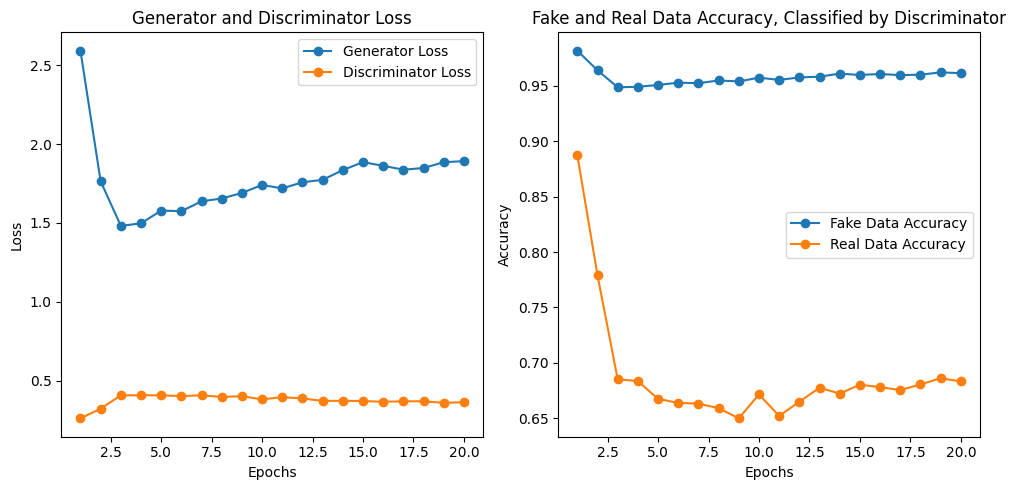

In [15]:
# Plotting
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(range(1, num_epochs + 1), loss['G'], label='Generator Loss', marker='o')
ax1.plot(range(1, num_epochs + 1), loss['D'], label='Discriminator Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Generator and Discriminator Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), acc['fake'], label='Fake Data Accuracy', marker='o')
ax2.plot(range(1, num_epochs + 1), acc['real'], label='Real Data Accuracy', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Fake and Real Data Accuracy, Classified by Discriminator')
ax2.legend()
plt.tight_layout()
plt.show()